# A priori experiments for the MIZ field campaignn

This test of whether any Argo floats have profiled within the MIZ region is to provide some context to oceanography we might expect and intialise 1D model simulations.

Author: Marcel du Plessis

Date: 4 September 2018

---

## Load the dependencies

In [1]:
%pylab inline
import pandas as pd
import tqdm
from tqdm import tqdm_notebook
from glob import glob
import cmocean
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
import scipy.interpolate
import xarray as xr


Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams.update({'font.size': 13})

rcParams['lines.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['ytick.direction'] = 'in'
rcParams['xtick.direction'] = 'in'

rcParams['axes.axisbelow'] = False
rcParams['axes.linewidth'] = 1.5

rcParams.update({'xtick.major.size': 7})
rcParams.update({'ytick.major.size': 7})
rcParams.update({'xtick.major.width': 1.5})
rcParams.update({'ytick.major.width': 1.5})
rcParams.update({'figure.figsize': [12, 5]})

## Read in raw netcdf Argo files

In [164]:
flist = '/Users/Marcel/Google Drive/Data/Argo/test/*.nc'
flist = glob(flist)

for f, fname in tqdm_notebook(enumerate(flist)): # runs through all the available argo files
    
    for i, val in enumerate(xds.N_PROF): # runs through all the profiles within each file
        
        ind = find(isnan(diff(xds.PRES[i, :]))==0) # finds the indicies where there are values
        
        t = xr.DataArray(xds.TEMP[i, ind].values, dims='pres', coords=[xds.PRES[i, ind].values]) # creation of data array
        s = xr.DataArray(xds.PSAL[i, ind].values, dims='pres', coords=[xds.PRES[i, ind].values]) # creation of data array
        
        t = t.interp(pres=arange(1000)).values # linear interpolation of temp to 0 - 1000 dbar
        s = s.interp(pres=arange(1000)).values # linear interpolation of salinity to 0 - 1000 dbar
        
        if f == 0 and i == 0: # this assigns the first profile you read to a new numpy array
            
            temp = t
            salt = s
            
        else: # each subsequent profile that is read in is stacked on top of all the one's you have read already
            
            temp = np.column_stack([temp, t]) 
            salt = np.column_stack([salt, t])
        
    if f == 0: # assigns numpy arrays for time, longtidue and latitude
    
        time = xds.JULD.values
        longitude = xds.LONGITUDE.values
        latitude = xds.LATITUDE.values
        
    else: # each subsequent time, longitude and latitude from the netcdfs in added to a single array
        
        time = np.append(time, xds.JULD.values)
        longitude = np.append(longitude, xds.LONGITUDE.values)
        latitude = np.append(latitude, xds.LATITUDE.values)

## Check the vertical gridding of the Argo dataset

In [114]:
xds = xr.open_dataset(flist[0])

for i, val in enumerate(xds.N_PROF):

    ind = find(isnan(diff(xds.PRES[i, :]))==0)
    
    if i == 0:
        x_hist = pd.Series(diff(xds.PRES[i, :])[ind])
        y_hist = pd.Series(xds.PRES[i, :-1][ind])
        
    if i > 0:
        x_hist = x_hist.append(pd.Series(diff(xds.PRES[i, :])[ind]))
        y_hist = y_hist.append(pd.Series(xds.PRES[i, :-1][ind]))

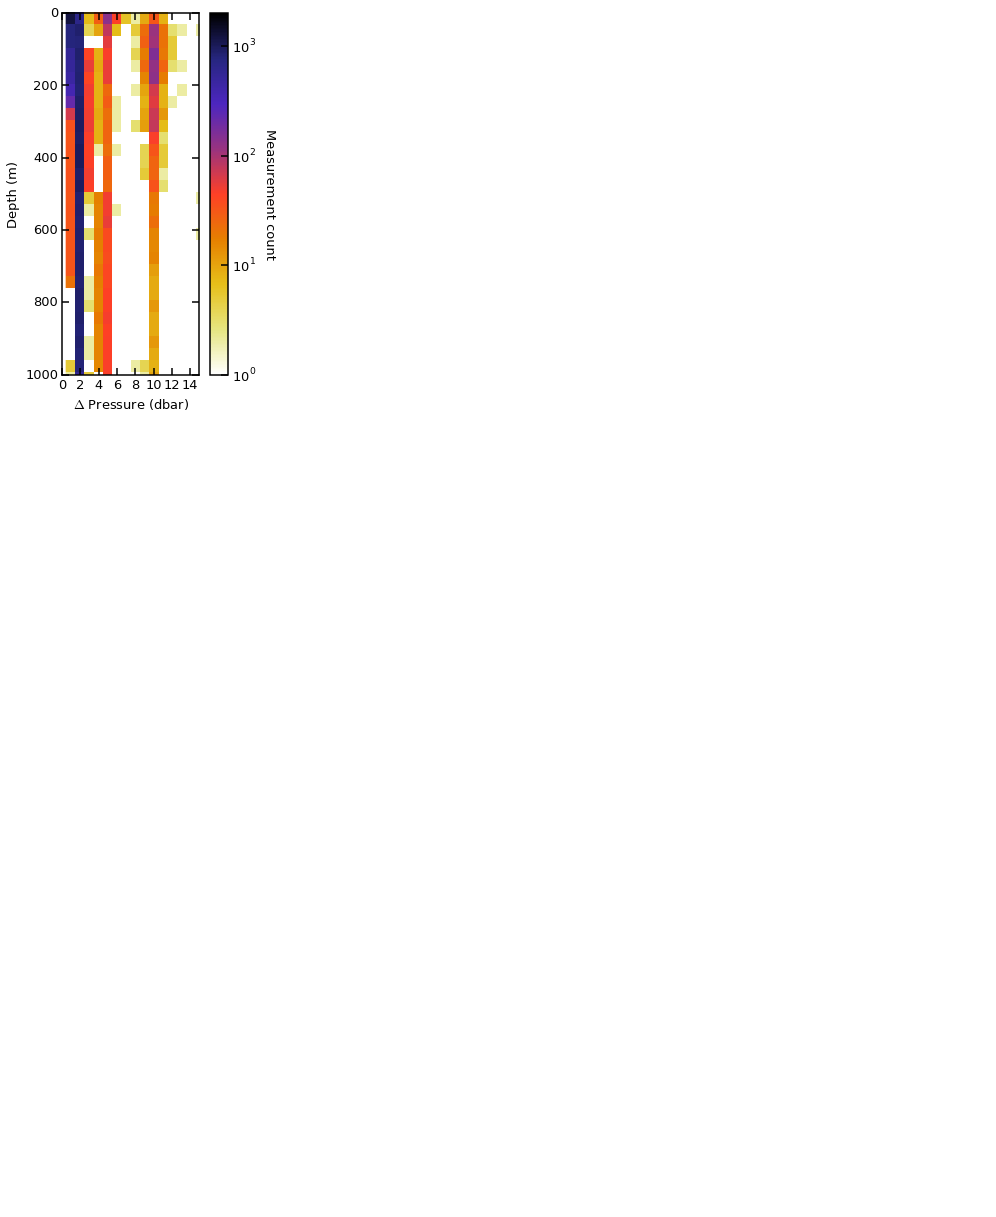

In [115]:
fig, ax = subplots(1, 1, figsize=[4, 6])
im = ax.hist2d(x_hist, y_hist, bins=100, norm=LogNorm(),
            rasterized=True, cmap='CMRmap_r', vmin=1, vmax=2e3)[-1]

ax.set_ylim(1000, 0)
ax.set_xlim(0, 15)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('$\Delta$ Pressure (dbar)')

cb = colorbar(mappable=im, ax=ax, fraction=0.15, pad=0.06)
cb.set_label('Measurement count', labelpad=20, rotation=-90)

fig.tight_layout()